#Model 6 (EfficientNet + Siamese)

In [ ]:
from h5py import File
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import permutation, randint, rand
import os
from tensorflow.keras.initializers import RandomNormal, Constant
import tensorflow as tf
from tensorflow.keras.backend import max, mean, sqrt, square, sum

import seaborn as sns
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.models import Model

from tensorflow import keras
from keras.layers import LeakyReLU, Softmax
from keras.layers import Conv2D, Activation, Input,Dropout,Lambda,Flatten, Dense
from keras.layers import Dense, Flatten, Reshape, Activation
from keras.layers import BatchNormalization ,ZeroPadding2D

from keras.layers import MaxPooling2D
from keras.layers import Concatenate
from keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from keras.layers import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow import one_hot, reshape


from tensorflow.keras.layers import Activation, Add, AvgPool2D, BatchNormalization, Conv2D, Dense, Flatten, Input, MaxPool2D, ZeroPadding2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from h5py import File
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import permutation, randint, rand
from numpy import rint
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

from numpy import expand_dims
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow import one_hot, reshape
from keras.layers import BatchNormalization
import cv2

# from keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model

In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0
Running on TPU  ['10.9.10.74:8470']


In [ ]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# with tpu_strategy.scope():
colab = True
# database = 'bigsig260_224x224_siamese_preprocessed.h5'
if colab:
    # from google.colab import drive
    # drive.mount('/content/gdrive')
    file = '/content/drive/MyDrive/bigsig260224x224x1_siamese_preprocessed.h5'
print(file)
with File(file, 'r') as hdf:
    S1 = np.array(hdf.get('S1'))
    S2 = np.array(hdf.get('S2'))
    Y = np.array(hdf.get('Y'))
print(S1.shape)
print(S2.shape)
print(Y.shape)

/content/drive/MyDrive/bigsig260224x224x1_siamese_preprocessed.h5
(29880, 224, 224, 1)
(29880, 224, 224, 1)
(29880, 1)


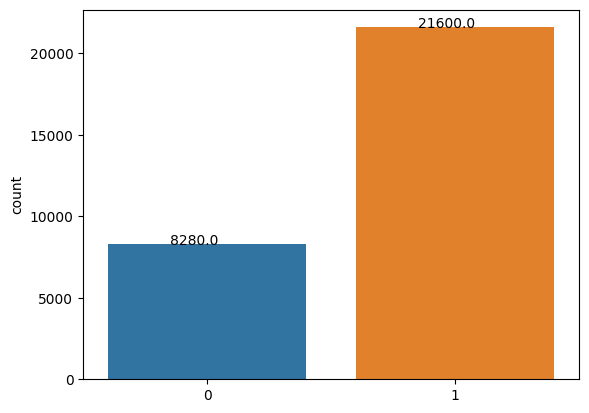

In [ ]:
ax = sns.countplot(x = Y.reshape(Y.shape[0]))
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

In [ ]:
21600/(21600 + 8280)

0.7228915662650602

In [ ]:
import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(Y),y = Y.reshape(Y.shape[0]))
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 1.8043478260869565, 1: 0.6916666666666667}

In [ ]:
Y = Y/1.0

In [ ]:
S1.dtype

dtype('uint8')

In [ ]:
seed=randint(10)
print('seed='+str(seed))
indices = permutation(Y.shape[0])
m = int(0.70 * Y.shape[0])
n = int(0.15 * Y.shape[0])
training_id, validation_id, test_id = indices[:m], indices[m: m + n], indices[m+n:]
S1_train, S1_test, S1_validate = S1[training_id], S1[test_id], S1[validation_id]
S2_train, S2_test, S2_validate = S2[training_id], S2[test_id], S2[validation_id]
Y_train, Y_test, Y_validate = Y[training_id], Y[test_id], Y[validation_id]
print(S1_train.shape)
print(S2_train.shape)
print(Y_train.shape)

del S1,S2,Y

seed=8
(20916, 224, 224, 1)
(20916, 224, 224, 1)
(20916, 1)


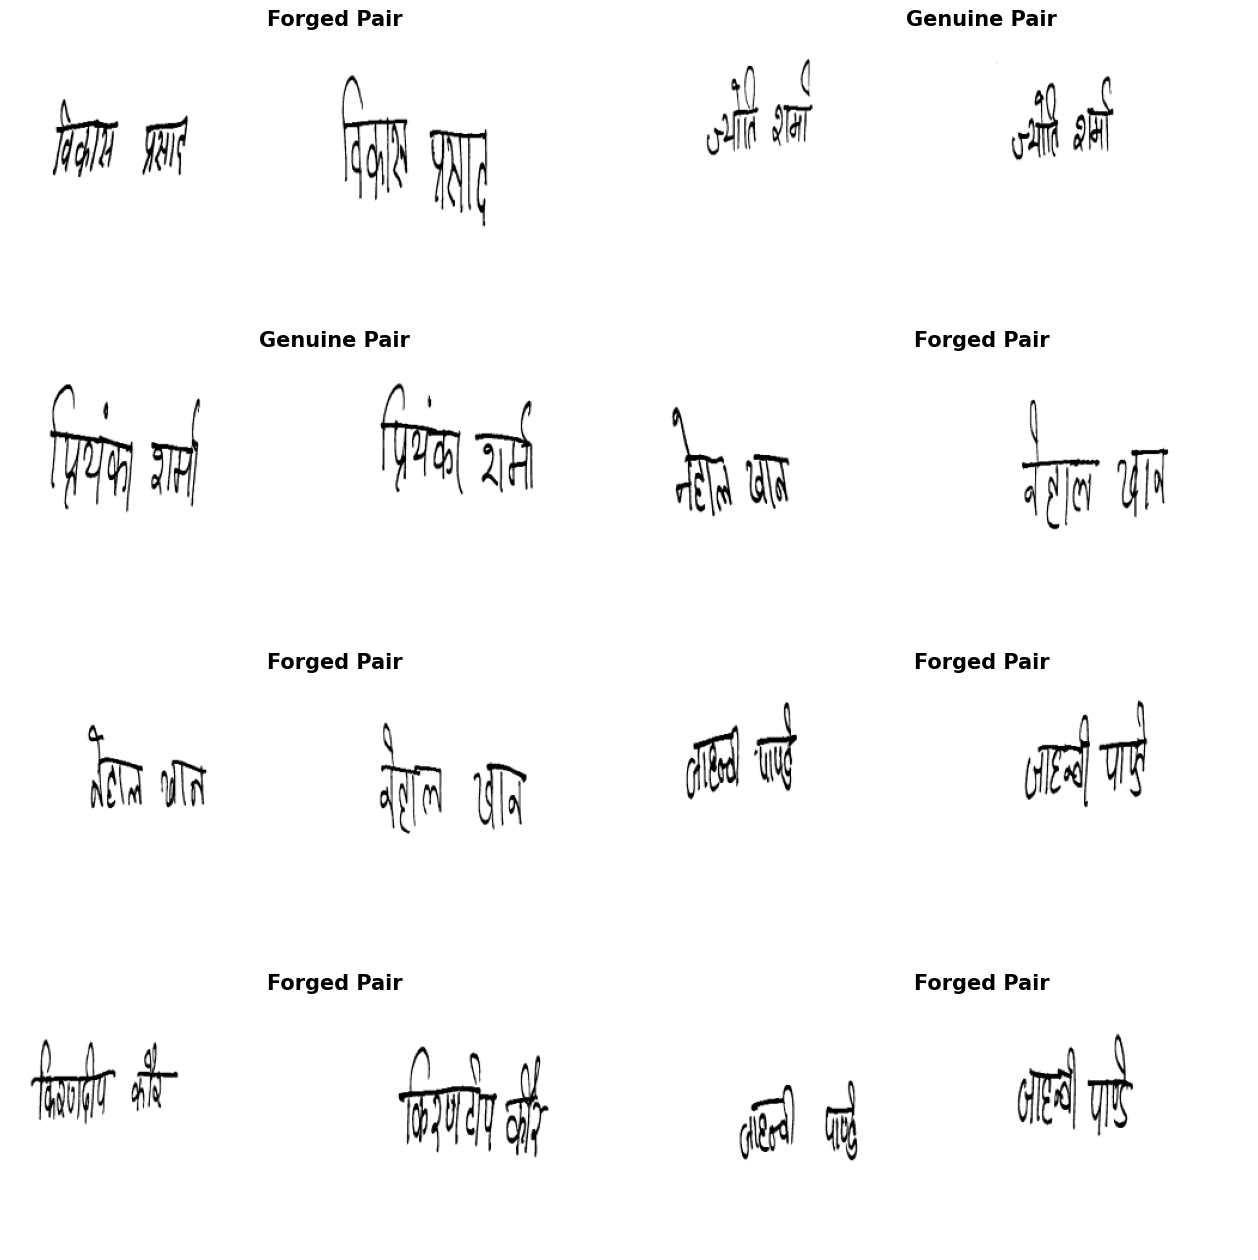

In [ ]:
fig = plt.figure(figsize = (16,16))
rows,cols = 4,4
i = 1
while(i in range(1,rows*cols)):
  random_idx = randint(0,len(S1_train))
  if(Y_train[random_idx] == 0):
    Label = "Genuine Pair"
  else:
    Label = "Forged Pair"
  img1 = S1_train[random_idx]
  img2 = S2_train[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img1.squeeze(),cmap = "gray");
  plt.axis(False);
  i += 1
  fig.add_subplot(rows,cols,i)
  plt.imshow(img2.squeeze(),cmap = "gray");
  plt.axis(False);
  plt.text(0.5, 0.5, Label, horizontalalignment='center',verticalalignment='center',fontsize=15,fontweight = 1000);
  i += 1

In [ ]:
Y_train[0]

array([1.])

In [ ]:
# #One hot Encoding
# Y_train = one_hot(Y_train, depth=2)
# Y_train = reshape(Y_train, (-1, 2))

# Y_test = one_hot(Y_test, depth=2)
# Y_test = reshape(Y_test, (-1, 2))

# Y_validate = one_hot(Y_validate, depth=2)
# Y_validate = reshape(Y_validate, (-1, 2))

In [ ]:
Y_train.shape

(20916, 1)

In [ ]:
input_shape=(224,224,1)
input_shape

(224, 224, 1)

In [ ]:
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [ ]:
def constructive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean(
        (1 - y_true) * square_pred + (y_true) * margin_square
    )

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
NUM_CLASSES = 2
IMG_SIZE = 224
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    x = inputs
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="relu", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model
    # inputs = layers.Input(shape = input_shape)
    # x = inputs
    # model = EfficientNetB0(include_top=False, input_tensor=x, weights = None)

    # # Freeze the pretrained weights
    # model.trainable = False

    # # Rebuild top
    # x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    # x = layers.BatchNormalization()(x)

    # top_dropout_rate = 0.5
    # x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    # outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    # return model


In [ ]:
plot_model(build_model(2))

In [ ]:
with tpu_strategy.scope():
# with tf.device('/device:GPU:0'):
  inputShape = S1_train.shape[1:]
  f = build_model(num_classes = 2)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
with tpu_strategy.scope():
  # network definition
  input_a = Input(shape=(input_shape))
  input_b = Input(shape=(input_shape))

  # because we re-use the same instance `base_network`,
  # the weights of the network
  # will be shared across the two branches
  processed_a = f(input_a)
  processed_b = f(input_b)

  # Compute the Euclidean distance between the two vectors in the latent space
  # https://keras.io/examples/vision/siamese_contrastive/
  merge_layer = layers.Lambda(euclidean_distance)([processed_a, processed_b])
  normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
  output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
  model = keras.Model(inputs=[input_a, input_b], outputs=output_layer)

In [ ]:
pred = model([expand_dims(S1_train[0],axis = 0), expand_dims(S2_train[0],axis = 0)])
print(pred.shape)
pred

(1, 1)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5238475]], dtype=float32)>

In [ ]:
folder = '/content/drive/MyDrive/EfficientNetHindi224x224x1Part2'

## **FINAL TRAINING**

***BEST LEARNING RATE IS 1e-04***

In [ ]:
Batch_size = 32
lr = 1e-04
Epochs = 60

In [ ]:
with tpu_strategy.scope():
    adam = Adam(learning_rate = lr,epsilon = 1e-08)
    model.compile(loss = constructive_loss, optimizer = adam, metrics=['BinaryAccuracy'])

In [ ]:
tf.config.experimental_connect_to_cluster(tf.distribute.cluster_resolver.TPUClusterResolver())

In [ ]:
# tf.tpu.experimental.initialize_tpu_system(tf.distribute.cluster_resolver.TPUClusterResolver().master())

AssertionError: ignored

In [ ]:
callbacks = [
    EarlyStopping(patience = 6, verbose = 1),
    ReduceLROnPlateau(factor=0.1, patience = 3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(folder + '/Weights/EffiNet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [ ]:
with tpu_strategy.scope():
  results = model.fit(x = [S1_train, S2_train],
                      y = Y_train,
                    validation_data = ([S1_validate,S2_validate],Y_validate),
                    epochs = Epochs,
                    callbacks = callbacks,
                    batch_size = Batch_size,
                    class_weight = class_weight_dict,
                    steps_per_epoch = S1_train.shape[0]//Batch_size-1,
                    validation_steps = S1_validate.shape[0]//Batch_size-1
                    # To fix Loss Nan on TPU
                    # https://stackoverflow.com/questions/64079759/validation-loss-become-nan-while-training-on-tpu-but-perfectly-ok-on-gpu
                    )

Epoch 1/60
651/652 [============================>.] - ETA: 0s - loss: 0.3061 - binary_accuracy: 0.5325
Epoch 1: saving model to /content/drive/MyDrive/EfficientNetHindi224x224x1Part2/Weights/EffiNet-bhsig260-001.h5
652/652 [==============================] - 88s 70ms/step - loss: 0.3061 - binary_accuracy: 0.5324 - val_loss: 0.2428 - val_binary_accuracy: 0.6120 - lr: 1.0000e-04
Epoch 2/60
651/652 [============================>.] - ETA: 0s - loss: 0.2542 - binary_accuracy: 0.5911
Epoch 2: saving model to /content/drive/MyDrive/EfficientNetHindi224x224x1Part2/Weights/EffiNet-bhsig260-002.h5
652/652 [==============================] - 38s 59ms/step - loss: 0.2542 - binary_accuracy: 0.5911 - val_loss: 0.1793 - val_binary_accuracy: 0.7014 - lr: 1.0000e-04
Epoch 3/60
651/652 [============================>.] - ETA: 0s - loss: 0.2339 - binary_accuracy: 0.6142
Epoch 3: saving model to /content/drive/MyDrive/EfficientNetHindi224x224x1Part2/Weights/EffiNet-bhsig260-003.h5
652/652 [==================

# Evaluation

In [ ]:
# Y_train.shape

In [ ]:
import pickle

In [ ]:
# with open(folder  + '/trainHistoryDict.h5', 'wb') as file_pi:
#        pickle.dump(results.history, file_pi)
# # model.save(folder + 'BestModel.h5')

In [ ]:
history_loaded = pickle.load(open(folder + '/trainHistoryDict.h5', "rb"))
# history_loaded

In [ ]:
# history_loaded = results

In [ ]:
best_result = history_loaded['val_loss'].index(min(history_loaded['val_loss'])) + 1
best_result

46

<ipython-input-31-2856f8786416>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


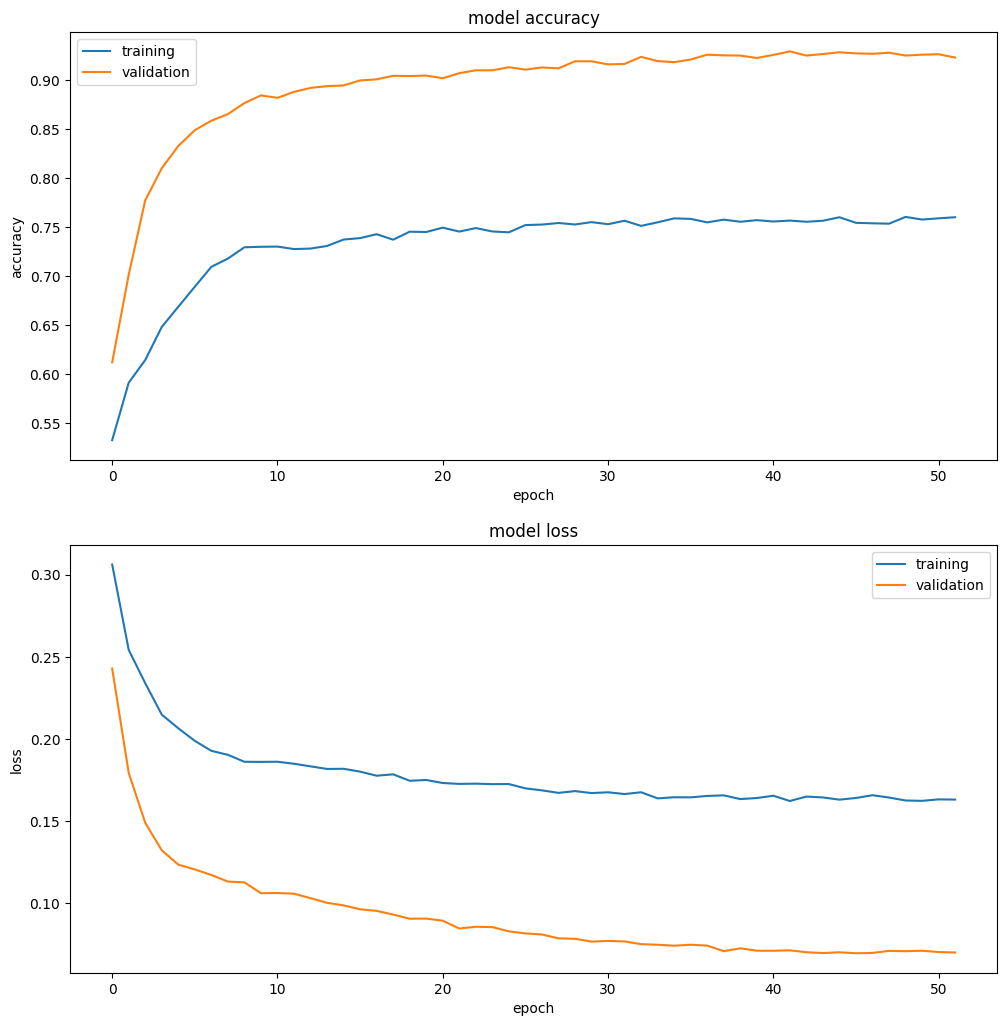

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history_loaded['binary_accuracy'], history_loaded['val_binary_accuracy'], 'accuracy', 211)
display_training_curves(history_loaded['loss'], history_loaded['val_loss'], 'loss', 212)
plt.savefig(folder + "loss_accuracy.svg",dpi = 1200)

In [ ]:
if(best_result < 10):
  model.load_weights(folder + f'/Weights/EffiNet-bhsig260-00{best_result}.h5')
else:
  model.load_weights(folder + f'/Weights/EffiNet-bhsig260-0{best_result}.h5')

In [ ]:
y_pred_keras = model.predict([S1_test, S2_test])

141/141 [==============================] - 24s 134ms/step


In [ ]:
y_pred_keras

array([[0.55407536],
       [0.99932563],
       [0.9224025 ],
       ...,
       [0.32901496],
       [0.9587754 ],
       [0.9988337 ]], dtype=float32)

In [ ]:
np.min(y_pred_keras),np.mean(y_pred_keras),np.max(y_pred_keras)

(0.32901496, 0.7550815, 0.9999997)

In [ ]:
# # if we keep threshold as fixed to the mean value
# threshold = 0.755

In [ ]:
def pred_threshold(y_pred_keras,threshold):
  y_pred_keras_new = np.zeros((len(y_pred_keras), 1), dtype = np.uint8)
  for i in range(len(y_pred_keras)):
    label = Y_test[i]
    if y_pred_keras[i] >= threshold:
      predicted_value = 1 # both different
      if(label == predicted_value):
        y_pred_keras_new[i] = label
      else:
        y_pred_keras_new[i] = predicted_value
    else:
        predicted_value = 0
        if(label == predicted_value):
          y_pred_keras_new[i] = label
        else:
            y_pred_keras_new[i] = predicted_value
  return y_pred_keras_new

{0.5: 0.9156229912033581, 0.501: 0.9157345258104277, 0.502: 0.9161508455439831, 0.503: 0.9159984529807402, 0.504: 0.9159984529807402, 0.505: 0.9159984529807402, 0.506: 0.9159984529807402, 0.507: 0.9158460604174973, 0.508: 0.9173589467884758, 0.509: 0.9174704813955454, 0.51: 0.9174704813955454, 0.511: 0.9174704813955454, 0.512: 0.9174704813955454, 0.513: 0.9174704813955454, 0.514: 0.9174704813955454, 0.515: 0.9173180888323025, 0.516: 0.9173180888323025, 0.517: 0.9198160072336348, 0.518: 0.9196636146703918, 0.519: 0.9195112221071489, 0.52: 0.9190540444174201, 0.521: 0.9190540444174201, 0.522: 0.9190540444174201, 0.523: 0.9190540444174201, 0.524: 0.9185968667276913, 0.525: 0.9182512236450321, 0.526: 0.9182512236450321, 0.527: 0.9182512236450321, 0.528: 0.9182512236450321, 0.529: 0.9182512236450321, 0.53: 0.9191953977192124, 0.531: 0.9191953977192124, 0.532: 0.9191953977192124, 0.533: 0.9190430051559696, 0.534: 0.9190430051559696, 0.535: 0.9190430051559696, 0.536: 0.9190430051559696, 0.537

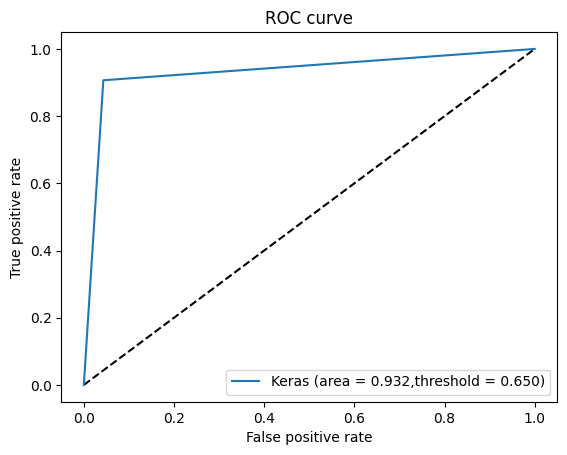

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
threshold_areas = {}
for i in np.arange(0.5,0.8,0.001):
  y_pred_keras_new = pred_threshold(y_pred_keras,i)
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras_new)
  auc_keras = auc(fpr_keras, tpr_keras)
  threshold_areas[i] = auc_keras
  # print(i,auc_keras)
print(threshold_areas)
max_value = list(threshold_areas.values())
max_key= list(threshold_areas.keys())
threshold = max_key[max_value.index(max(max_value))]
y_pred_keras_new = pred_threshold(y_pred_keras,threshold)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras_new)
auc_keras = auc(fpr_keras, tpr_keras)
print("False Positive Rate : ",fpr_keras[1],"\nTrue Positive Rate :",tpr_keras[1])
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f},threshold = {:.3f})'.format(auc_keras,threshold))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(folder + "roc.svg",dpi = 1200)
plt.show()

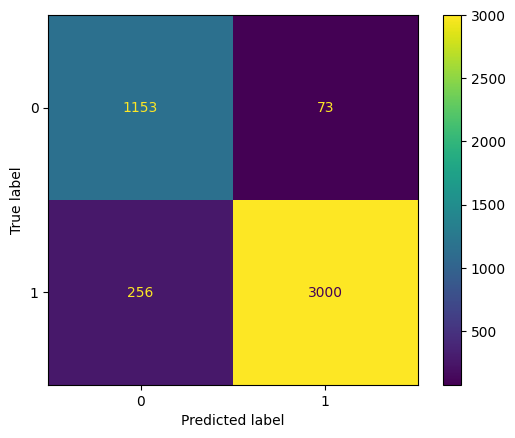

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(Y_test,y_pred_keras_new)).plot()
plt.savefig(folder + "confusionmatrix.svg",dpi = 1200)
plt.show()

#### Load the weights from the epoch which gave the best validation accuracy

In [ ]:
i = 0
test_gen = ([S1_test[i],S2_test[i]],Y_test[i])
(img1, img2), label = test_gen
result = model([np.expand_dims(a = img1,axis = 0), np.expand_dims(a = img2,axis = 0)])

In [ ]:
result.numpy()[0][0]

0.99851847

In [ ]:
def predict_score(i = 0):
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_gen = ([S1_test[i],S2_test[i]],Y_test[i])
    (img1, img2), label = test_gen

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if label == 0:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model([np.expand_dims(a = img1,axis = 0), np.expand_dims(a = img2,axis = 0)])
    diff = result.numpy()[0][0]
    print("Difference Score = ", diff)
    if diff >= threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

In [ ]:
def test_accuracy():
    '''Predict distance score and classify test images as Genuine or Forged'''
    predicted_labels = []
    # y_pred_keras_new
    for i in range(len(S1_test)):
      test_gen = ([S1_test[i],S2_test[i]],Y_test[i])
      (img1, img2), label = test_gen
      if(label == y_pred_keras_new[i]):
        predicted_labels.append(True) # append True for correct value else false
      else:
        predicted_labels.append(False)
    correct_prediction = predicted_labels.count(True)
    return (correct_prediction/len(S1_test))*100,predicted_labels

In [ ]:
with tpu_strategy.scope():
  test_acc,predicted_labels = test_accuracy()

In [ ]:
test_acc

92.6595269968764

In [ ]:
predicted_labels.count(True)/len(predicted_labels)*100

92.6595269968764

In [ ]:
predicted_labels.count(False)

329

### Note: The first image is always Genuine. Score prediction and classification is done for the second image

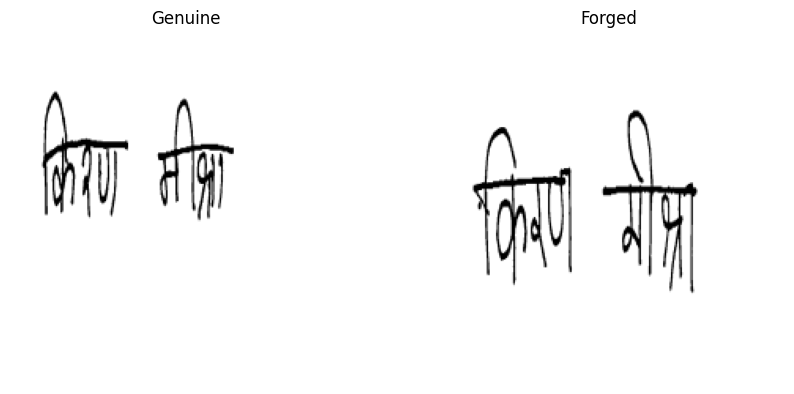

Difference Score =  0.99851847
Its a Forged Signature


In [ ]:
predict_score(0)

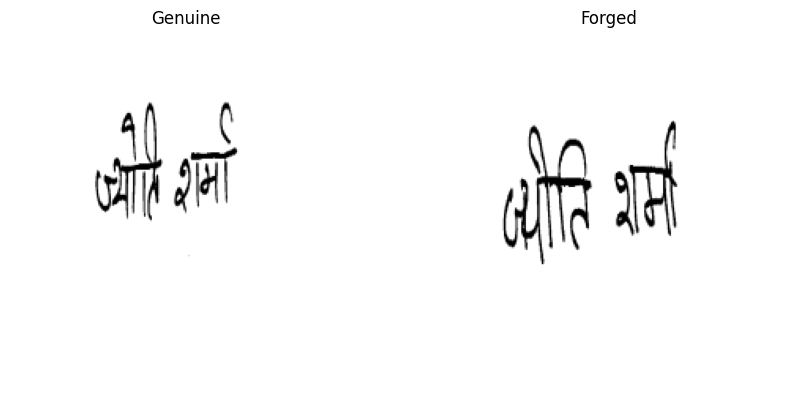

Difference Score =  0.9616341
Its a Forged Signature


In [ ]:
predict_score(1)

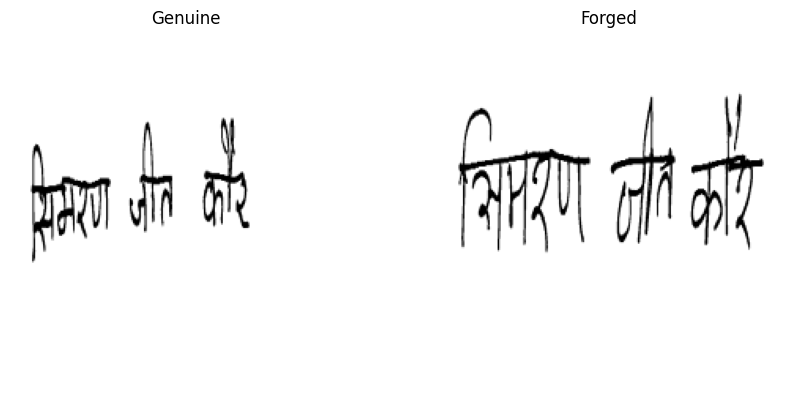

Difference Score =  0.9941176
Its a Forged Signature


In [ ]:
predict_score(2)

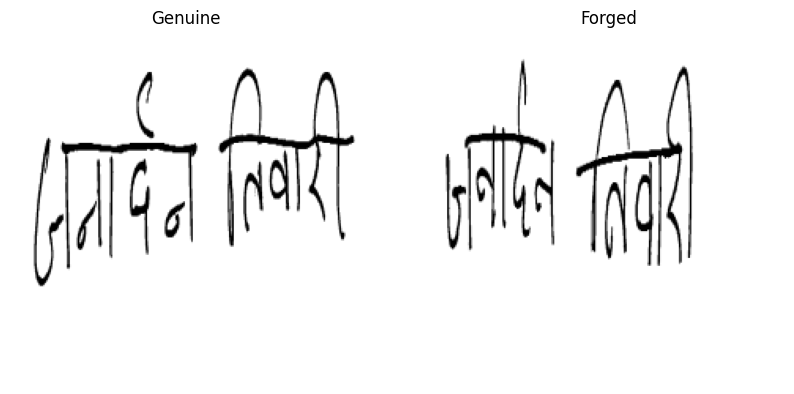

Difference Score =  0.970948
Its a Forged Signature


In [ ]:
predict_score(10)

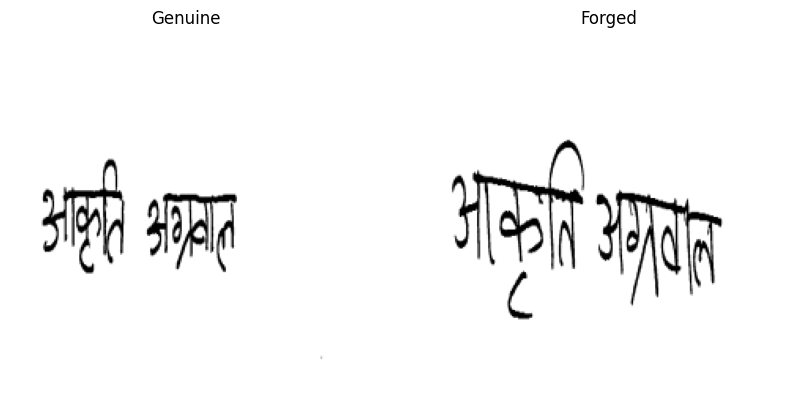

Difference Score =  0.99911666
Its a Forged Signature


In [ ]:
predict_score(11)

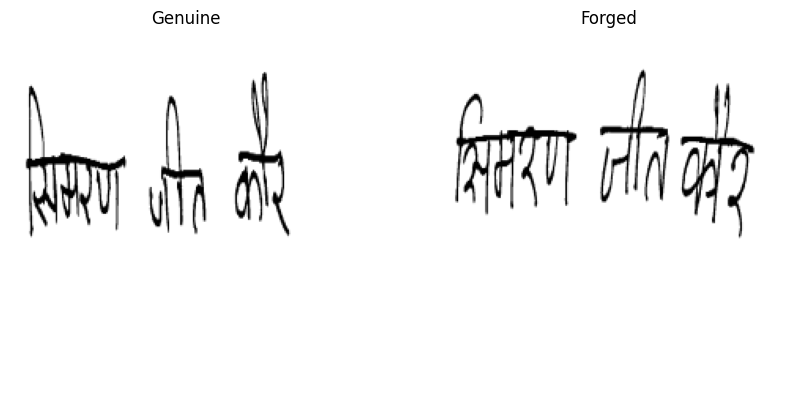

Difference Score =  0.8319302
Its a Forged Signature


In [ ]:
predict_score(13)

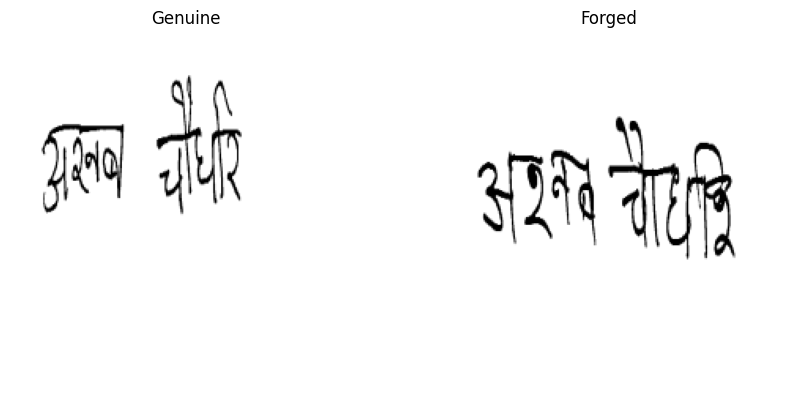

Difference Score =  0.96362895
Its a Forged Signature


In [ ]:
predict_score(8)

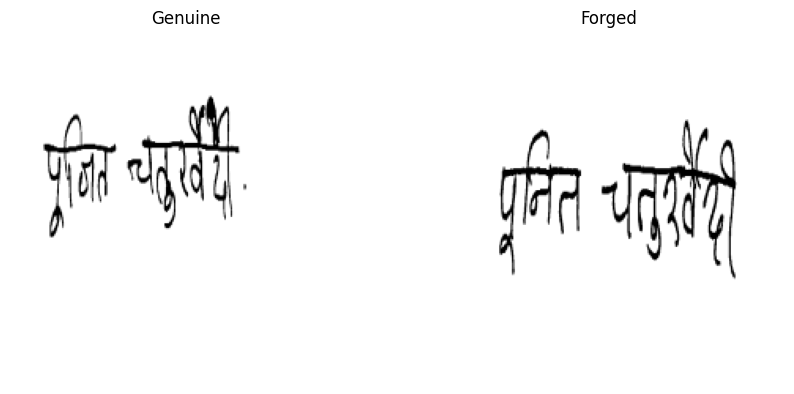

Difference Score =  0.78907496
Its a Forged Signature


In [ ]:
predict_score(19)

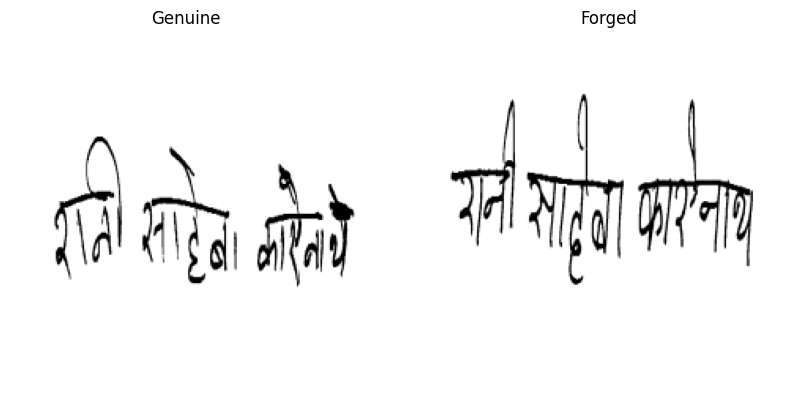

Difference Score =  0.99644685
Its a Forged Signature


In [ ]:
predict_score(20)

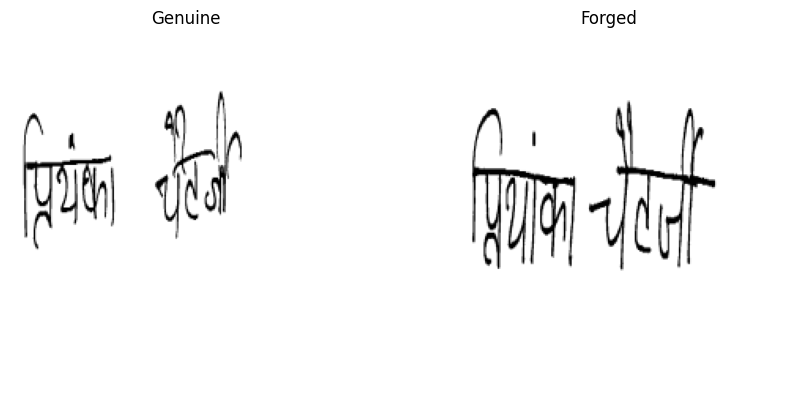

Difference Score =  0.9951913
Its a Forged Signature


In [ ]:
predict_score(12)

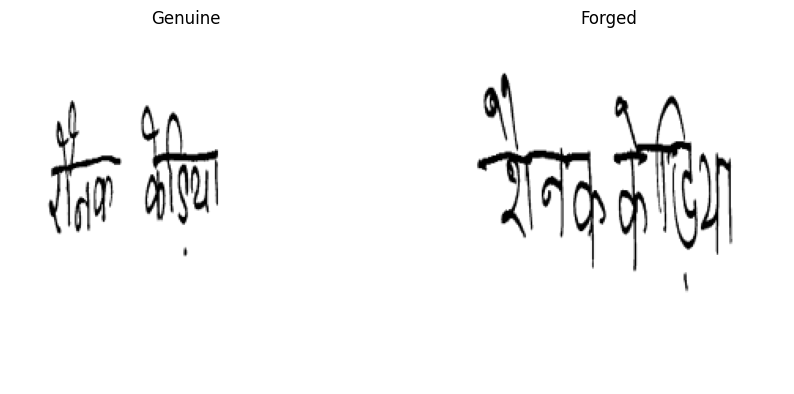

Difference Score =  0.9999387
Its a Forged Signature


In [ ]:
predict_score(15)

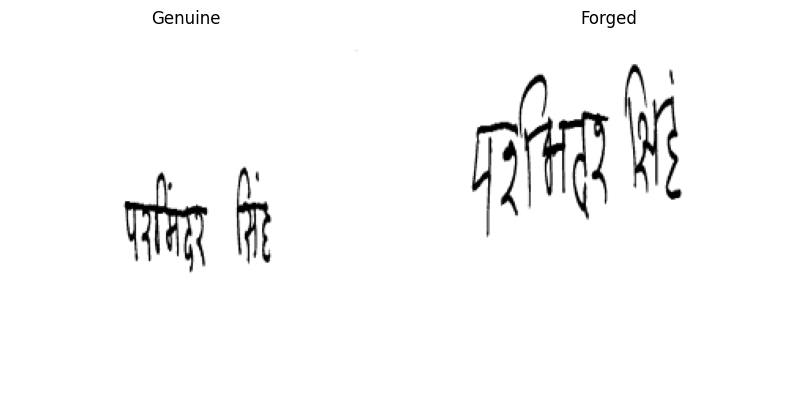

Difference Score =  0.88569486
Its a Forged Signature


In [ ]:
predict_score(16)

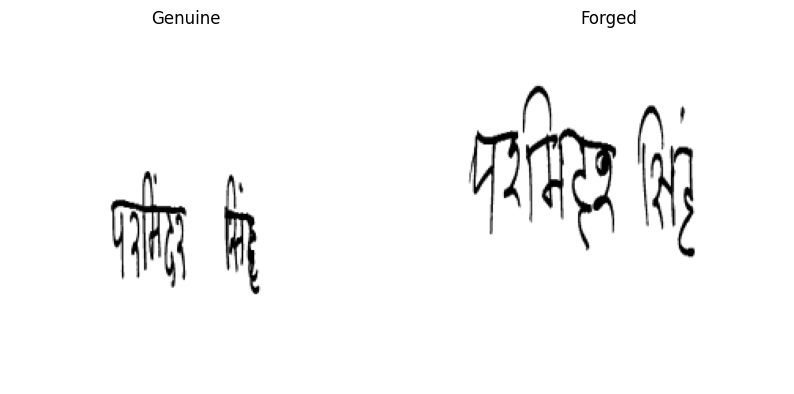

Difference Score =  0.87014043
Its a Forged Signature


In [ ]:
predict_score(30)

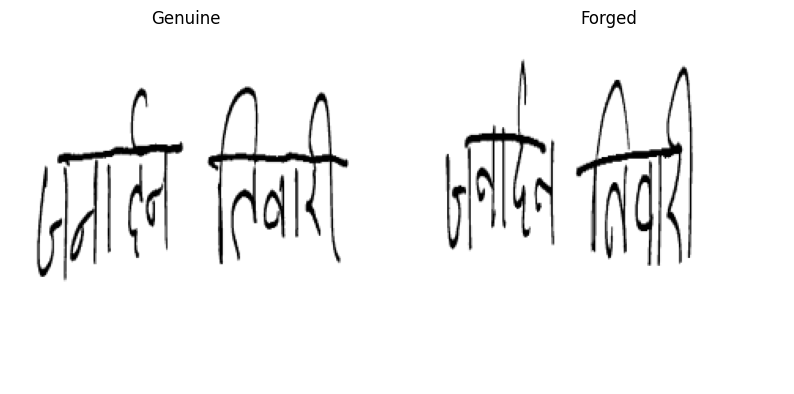

Difference Score =  0.9855374
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

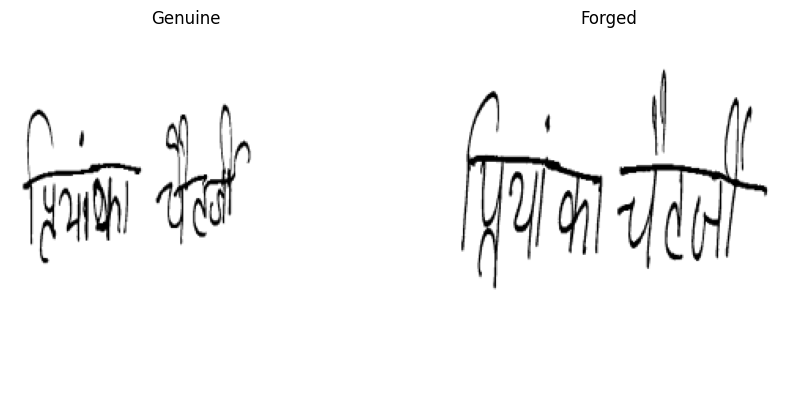

Difference Score =  0.98797905
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

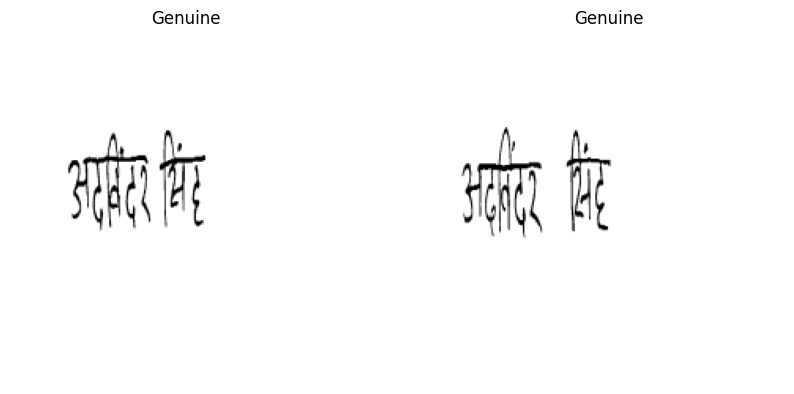

Difference Score =  0.32901025
Its a Genuine Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

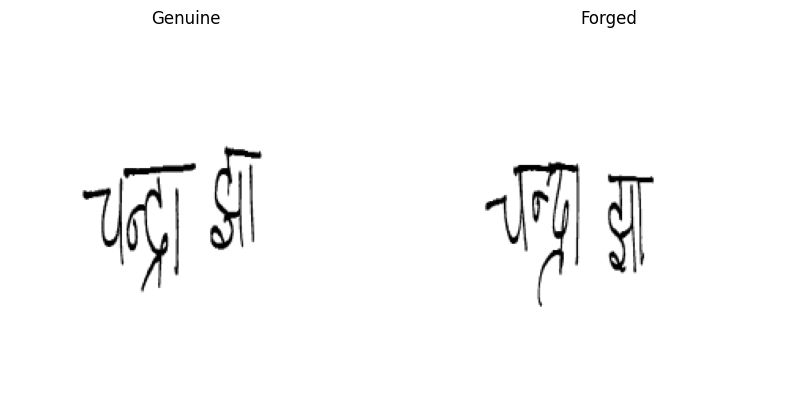

Difference Score =  0.43026444
Its a Genuine Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

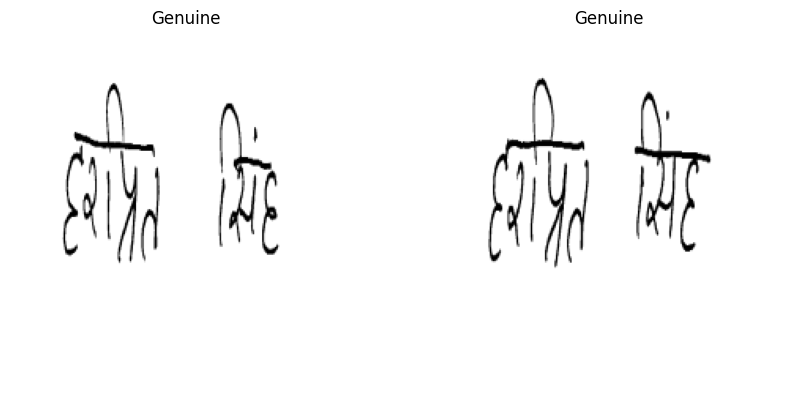

Difference Score =  0.63433075
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

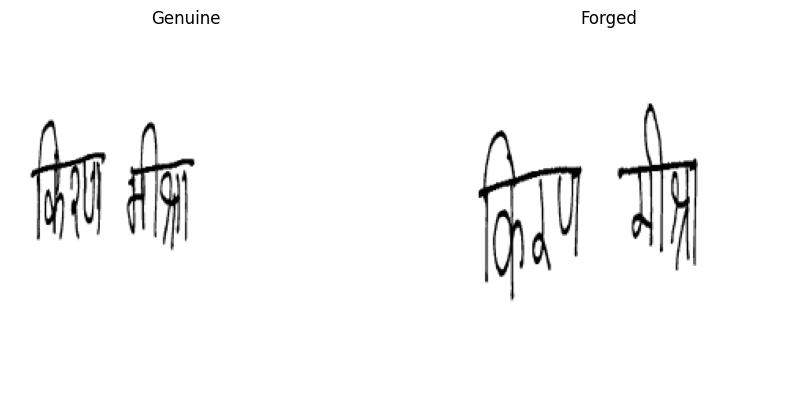

Difference Score =  0.98689026
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

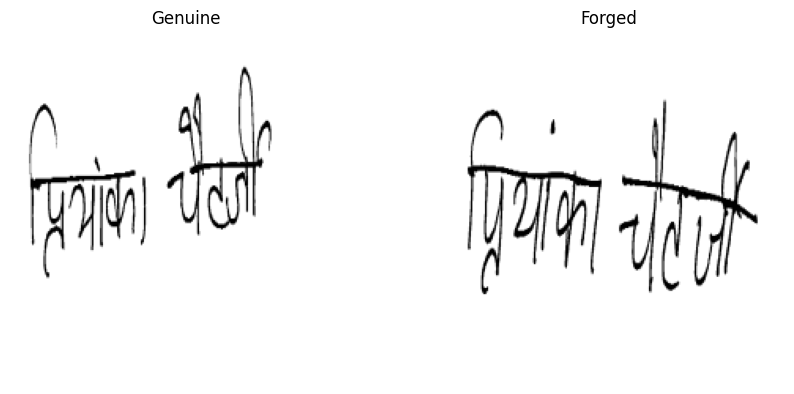

Difference Score =  0.9978987
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

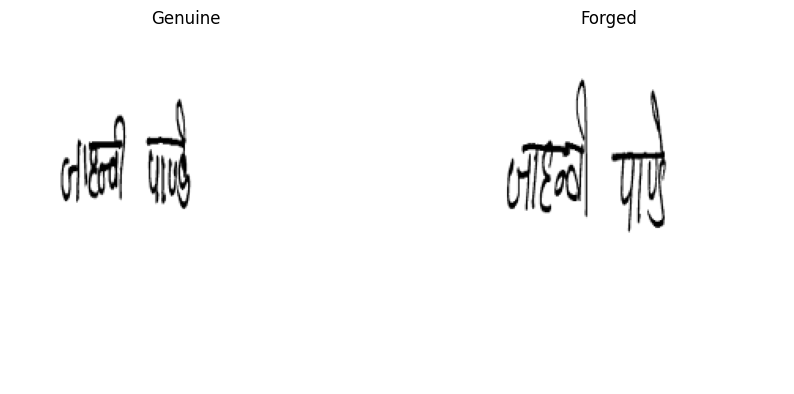

Difference Score =  0.94553477
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

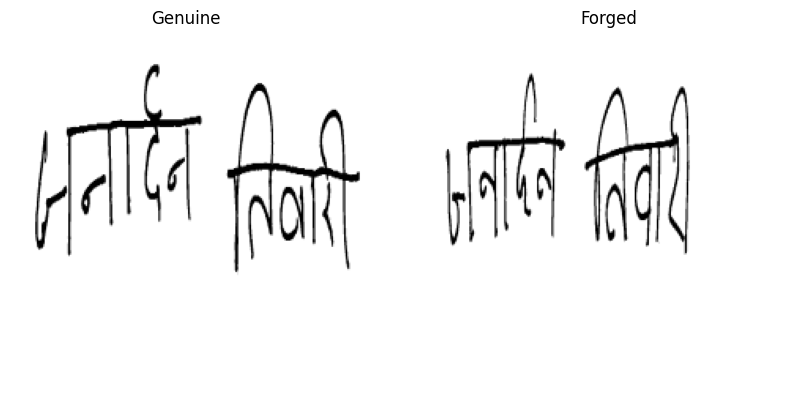

Difference Score =  0.95464015
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

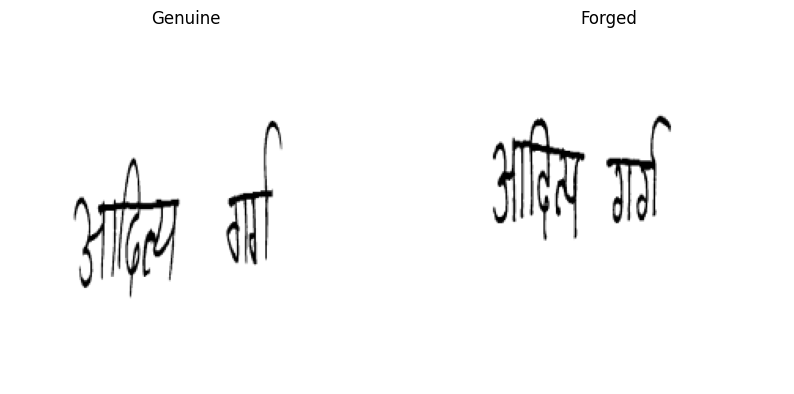

Difference Score =  0.67217237
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

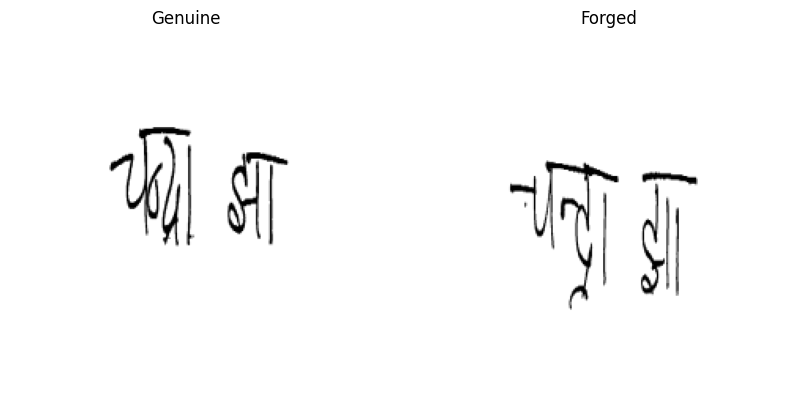

Difference Score =  0.99994135
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

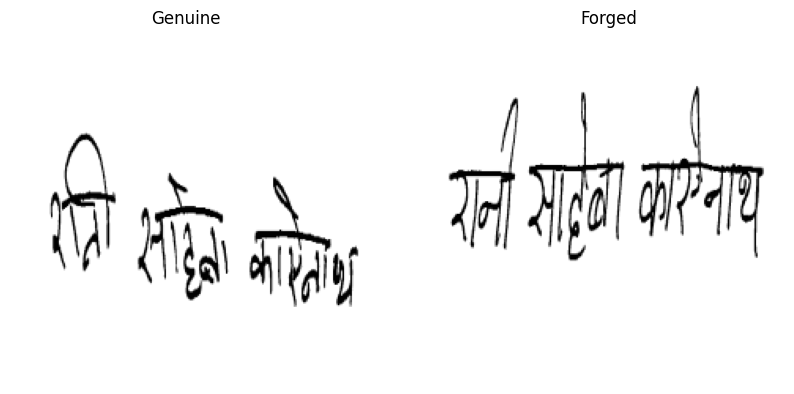

Difference Score =  0.9992669
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

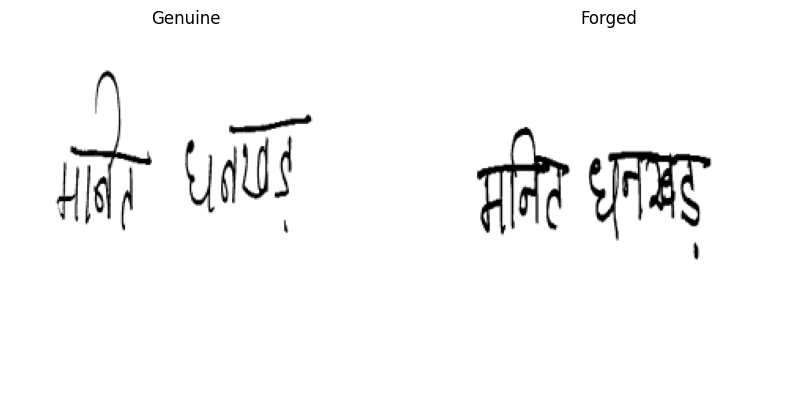

Difference Score =  0.9085497
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

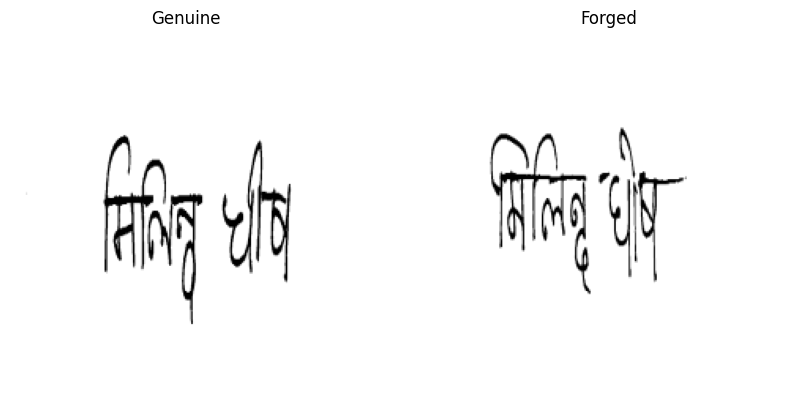

Difference Score =  0.90416783
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

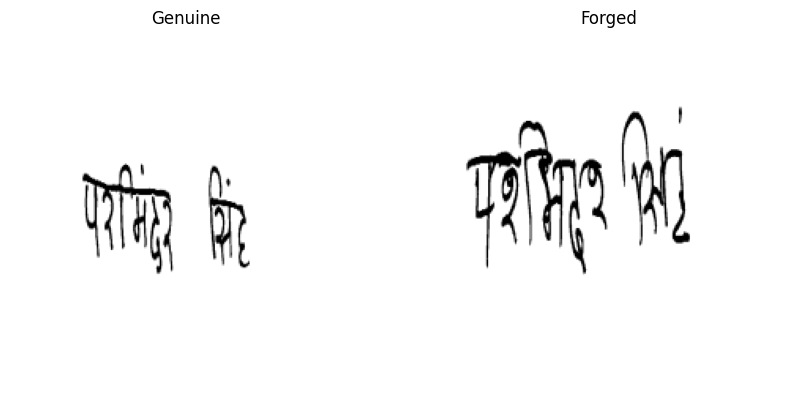

Difference Score =  0.9744856
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

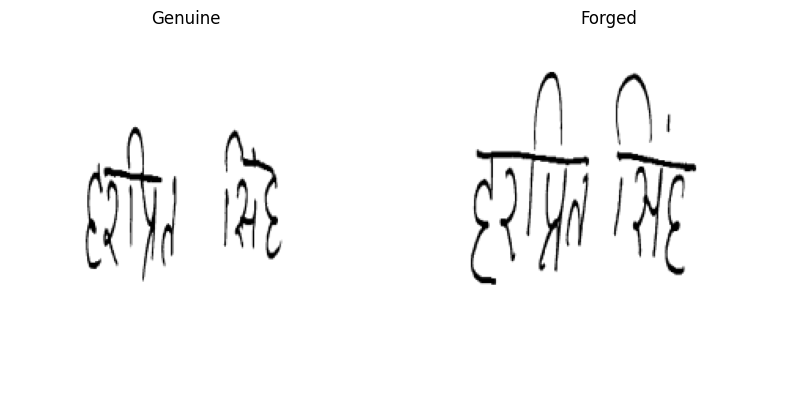

Difference Score =  0.99144185
Its a Forged Signature


In [ ]:
predict_score(randint(0,len(S1_test)))

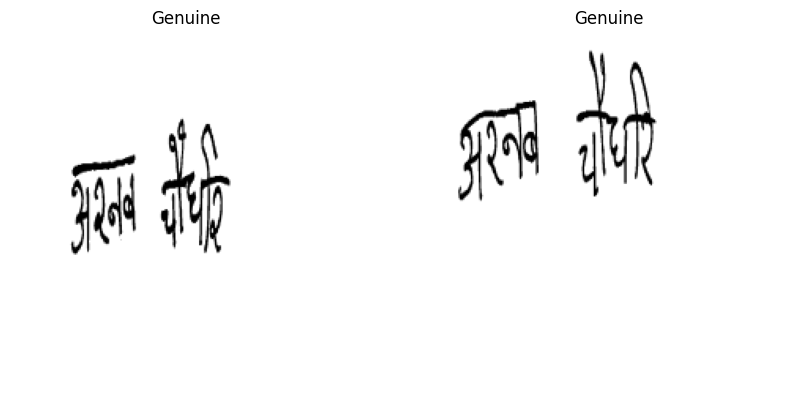

Difference Score =  0.32901025
Its a Genuine Signature


In [ ]:
predict_score(randint(0,len(S1_test)))